# Reproducing Balachandran et el. results

The aim of this document is to analyse the reprodcibility of Balachandran study (Balachandran et al. (2017). Identification of unique neoantigen qualities in long-term survivors of pancreatic cancer. Nature, 551(7681), S12–S16. https://doi.org/10.1038/nature24462) using Neofox.

For this purpose we will use the supplementary table 1 provided here https://static-content.springer.com/esm/art%3A10.1038%2Fnature24462/MediaObjects/41586_2017_BFnature24462_MOESM2_ESM.xlsx. This table contains 4,870 unique neoepitope candidates from 58 patients, including the MHC I alleles for each of the patients. Some of the neoepitopes are assessed against more than one HLA allele, as this are chosen when having an affinity lower than 500 nM (**is this right?**)

The previous data will be the input for Neofox. We will use this to calculate the amplitude score as described in their paper and compare it to Neofox implementation.

\begin{equation*}
amplitude = \frac{affinity^{wild type}}{affinity^{mutant}}
\end{equation*}

Both Neofox and Balanchandran rely on NetMHCpan to calculate the binding affinities to each MHC I allele. While Neofox uses NetMHCpan 4.0, Balachandran uses NetMHCpan 3.4, thus there is some expected variability. We need to evaluate first the selection of the best binding MHC allele and then for those in agreement compare the amplitudes.


## Read supplementary table 1

The supplementary table 1 contains neoepitope candidates for 58 pancreatic cancer patients. There is a total of 5278 points, where 4870 are unique neoepitopes in a patient, but all HLA alleles with binding affinity < 500 nM are reported.

In [1]:
import pandas as pd

In [2]:
table_1 = pd.read_excel("balachandran/41586_2017_BFnature24462_MOESM2_ESM.xlsx", header=4)
# we need to remove some rows blank rows from the Excel sheet between patients 32 and 33
table_1.dropna(inplace=True)

In [3]:
table_1.head()

,Patient Number,HLA alleles,WT Peptide,MT Peptide,WT Allele,MT Allele,WT Binding Score,MT Binding Score
0,1.0,"A1102,A1112,B4001,B1301,C0702,C0303",Riqdlytvl,Hiqdlytvl,C0702,C0702,605.0,168.0
1,1.0,"A1102,A1112,B4001,B1301,C0702,C0303",gNytllnvf,gYytllnvf,C0702,C0702,7448.0,178.0
2,1.0,"A1102,A1112,B4001,B1301,C0702,C0303",ltlfgNytl,ltlfgYytl,C0303,C0303,56.0,19.0
3,1.0,"A1102,A1112,B4001,B1301,C0702,C0303",tlfgNytll,tlfgYytll,C0303,C0303,36.0,84.0
4,1.0,"A1102,A1112,B4001,B1301,C0702,C0303",Nytllnvfl,Yytllnvfl,C0702,C0702,853.0,136.0


In [4]:
# total number of data points
table_1.shape

(5278, 8)

In [5]:
# list of patients
table_1["Patient Number"].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58.])

In [6]:
# unique neoepitopes reported in each patient
table_1[["Patient Number", "WT Peptide", "MT Peptide"]].drop_duplicates().shape

(4870, 3)

Calculate the amplitude on the provided data as the ratio between wild type peptide affinity and mutant peptide affinity.

In [7]:
table_1["amplitude"] = table_1["WT Binding Score"] / table_1["MT Binding Score"]
table_1.head()

,Patient Number,HLA alleles,WT Peptide,MT Peptide,WT Allele,MT Allele,WT Binding Score,MT Binding Score,amplitude
0,1.0,"A1102,A1112,B4001,B1301,C0702,C0303",Riqdlytvl,Hiqdlytvl,C0702,C0702,605.0,168.0,3.601190
1,1.0,"A1102,A1112,B4001,B1301,C0702,C0303",gNytllnvf,gYytllnvf,C0702,C0702,7448.0,178.0,41.842697
2,1.0,"A1102,A1112,B4001,B1301,C0702,C0303",ltlfgNytl,ltlfgYytl,C0303,C0303,56.0,19.0,2.947368
3,1.0,"A1102,A1112,B4001,B1301,C0702,C0303",tlfgNytll,tlfgYytll,C0303,C0303,36.0,84.0,0.428571
4,1.0,"A1102,A1112,B4001,B1301,C0702,C0303",Nytllnvfl,Yytllnvfl,C0702,C0702,853.0,136.0,6.272059


All peptides are 9-mers, except precisely 9 peptides for which both the wild type and the mutant end with an asterisk. These are stripped of the asterisk for the analysis in neofox and will be thus analysed as 8-mers.

In [8]:
table_1["len_MT_peptide"] = table_1["MT Peptide"].transform(lambda x: len(x))
table_1["len_WT_peptide"] = table_1["WT Peptide"].transform(lambda x: len(x))

In [9]:
table_1["len_MT_peptide"].value_counts()

9    5278
Name: len_MT_peptide, dtype: int64

In [10]:
table_1["len_WT_peptide"].value_counts()

9    5278
Name: len_WT_peptide, dtype: int64

In [11]:
table_1[table_1["WT Peptide"].transform(lambda p: "*" in p)]

,Patient Number,HLA alleles,WT Peptide,MT Peptide,WT Allele,MT Allele,WT Binding Score,MT Binding Score,amplitude,len_MT_peptide,len_WT_peptide
177,4.0,"A6801,A0201,B1501,B5101,C0501,C0303",ylinGmyl*,ylinEmyl*,A0201,A0201,5.0,7.0,0.714286,9,9
409,10.0,"A0302,A2402,B1402,B3501,C0401,C0815",fylPyfek*,fylRyfek*,A2402,A2402,279.0,238.0,1.172269,9,9
1217,13.0,"A0101,A2601,B3502,B3801,C1203,C0401",raeRfgia*,raeHfgia*,C1203,C1203,227.0,198.0,1.146465,9,9
1399,13.0,"A0101,A2601,B3502,B3801,C1203,C0401",rllppAsp*,rllppVsp*,C1203,C1203,488.0,269.0,1.814126,9,9
1973,16.0,"A1101,A0301,B1502,B0702,C0801,C0102",vpewsDns*,vpewsNns*,B0702,B0702,1444.0,291.0,4.962199,9,9
2740,29.0,"A3201,A2402,B2707,B0702,C1502,C0401",yyflcPll*,yyflcLll*,A2402,A2402,76.0,179.0,0.424581,9,9
4865,45.0,"A2402,A0101,B0801,B5001,C0701,C0701",yyflcPll*,yyflcLll*,A2402,A2402,76.0,179.0,0.424581,9,9
4866,45.0,"A2402,A0101,B0801,B5001,C0701,C0701",yyflCpll*,yyflRpll*,A2402,A2402,76.0,82.0,0.926829,9,9
4867,45.0,"A2402,A0101,B0801,B5001,C0701,C0701",yyflCpll*,yyflRpll*,C0701,C0701,441.0,289.0,1.525952,9,9


## Transform data into Neofox models

In order to run Neofox we need to transform the data into something Neofox understands. The Neofox models come with validation and normalization functionality to adapt to heterogeneous datasets. In this case we can observe that the MHC allele representation do not follow the HLA allele nomenclature (http://hla.alleles.org/nomenclature/index.html), ie: `A1102` instead of `HLA-A*11:02`; and the peptides are represented with lower and upper case.

### Parse the patients and the HLA alleles

Using the validation function for patients available in `ModelValidator.validate_patient()` and the method to parse MHC I alleles available in `ModelConverter.parse_mhc1_alleles()` we ensure that the patient and HLA representations are valid and we get a normalized allele representation according to http://hla.alleles.org/nomenclature/naming.html. During HLA allele validation only classic genes are allowed; heterogeneous HLA representations are accepted.

In [12]:
patients = table_1[["Patient Number", "HLA alleles"]].drop_duplicates()
patients

,Patient Number,HLA alleles
0,1.0,"A1102,A1112,B4001,B1301,C0702,C0303"
38,2.0,"A0101,A0201,B5201,B3901,C1203,C1203"
98,3.0,"A1101,A0201,B0702,B5201,C0702,C1202"
126,4.0,"A6801,A0201,B1501,B5101,C0501,C0303"
206,5.0,"A0301,A6901,B0702,B0702,C0702,C0303"
305,6.0,"A3601,A3303,B5301,B1516,C1402,C0401"
325,7.0,"A0201,A0201,B4402,B4402,C0517,C0501"
330,8.0,"A0101,A0301,B4401,B0801,C0704,C0701"
362,9.0,"A0301,A2402,B3503,B3503,C1203,C0401"
384,10.0,"A0302,A2402,B1402,B3501,C0401,C0815"


In [13]:
from neofox.model.neoantigen import Patient
from neofox.model.conversion import ModelConverter, ModelValidator
import json

In [14]:
patients_neofox = []
for _, row in patients.iterrows():
    patients_neofox.append(
        ModelValidator.validate_patient(
            Patient(
                identifier=str(row["Patient Number"]),
                mhc1=ModelConverter.parse_mhc1_alleles(row["HLA alleles"].split(",")))))

In [15]:
print(json.dumps(patients_neofox[0].to_dict(), indent=3))

{
   "identifier": "1.0",
   "mhc1": [
      {
         "zygosity": "HETEROZYGOUS",
         "alleles": [
            {
               "fullName": "HLA-A*11:02",
               "name": "HLA-A*11:02",
               "gene": "A",
               "group": "11",
               "protein": "02"
            },
            {
               "fullName": "HLA-A*11:12",
               "name": "HLA-A*11:12",
               "gene": "A",
               "group": "11",
               "protein": "12"
            }
         ]
      },
      {
         "name": "B",
         "zygosity": "HETEROZYGOUS",
         "alleles": [
            {
               "fullName": "HLA-B*40:01",
               "name": "HLA-B*40:01",
               "gene": "B",
               "group": "40",
               "protein": "01"
            },
            {
               "fullName": "HLA-B*13:01",
               "name": "HLA-B*13:01",
               "gene": "B",
               "group": "13",
               "protein": "01"
         

### Parse the neoantigen candidates

Using the validation function for neoantigens available in `ModelValidator.validate_neoantigen()` we ensure that the neoantigen representation is valid. Every aminoacid is checked to be a valid IUPAC code and they are upper cased. A unique identifier is built for the neoantigen and the 0-based position/s of the mutation/s within the peptide are calculated.

In [16]:
neoantigens = table_1[["Patient Number", "WT Peptide", "MT Peptide"]]
# we remove duplicates as some neoantigens are repeated as they are evaluated for different alleles
neoantigens.drop_duplicates(inplace=True)

/home/priesgo/src/addannot/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
neoantigens.shape

(4870, 3)

In [18]:
neoantigens.head()

,Patient Number,WT Peptide,MT Peptide
0,1.0,Riqdlytvl,Hiqdlytvl
1,1.0,gNytllnvf,gYytllnvf
2,1.0,ltlfgNytl,ltlfgYytl
3,1.0,tlfgNytll,tlfgYytll
4,1.0,Nytllnvfl,Yytllnvfl


In [19]:
# for some reason there are some neoantigens that end with a *, we remove that
neoantigens[neoantigens["WT Peptide"].transform(lambda p: "*" in p)]

,Patient Number,WT Peptide,MT Peptide
177,4.0,ylinGmyl*,ylinEmyl*
409,10.0,fylPyfek*,fylRyfek*
1217,13.0,raeRfgia*,raeHfgia*
1399,13.0,rllppAsp*,rllppVsp*
1973,16.0,vpewsDns*,vpewsNns*
2740,29.0,yyflcPll*,yyflcLll*
4865,45.0,yyflcPll*,yyflcLll*
4866,45.0,yyflCpll*,yyflRpll*


In [20]:
from neofox.model.neoantigen import Neoantigen, Mutation
from neofox.model.conversion import ModelValidator

In [21]:
neoantigens_neofox = []
for _, row in neoantigens.iterrows():
    neoantigens_neofox.append(
        ModelValidator.validate_neoantigen(
            Neoantigen(
                patient_identifier=str(row["Patient Number"]),
                mutation=Mutation(
                    mutated_xmer=row["MT Peptide"].strip("*"),   # here we strip the *
                    wild_type_xmer=row["WT Peptide"].strip("*")))))

In [22]:
print(json.dumps(neoantigens_neofox[0].to_dict(), indent=3))

{
   "identifier": "bPR1hUExGJn3+aOKrqy3gw==",
   "patientIdentifier": "1.0",
   "mutation": {
      "position": [
         1
      ],
      "wildTypeXmer": "RIQDLYTVL",
      "mutatedXmer": "HIQDLYTVL"
   }
}


In [138]:
# export the parsed data into JSON
json.dump(json.dumps([n.to_dict() for n in neoantigens_neofox]), open("balachandran/supplementary_table1_neoantigens.json", "w"))
json.dump(json.dumps([p.to_dict() for p in patients_neofox]), open("balachandran/supplementary_table1_patients.json", "w"))

In [141]:
neoantigens_neofox_df = ModelConverter.objects2dataframe(neoantigens_neofox)
neoantigens_neofox_df.to_csv("balachandran/supplementary_table1_neoantigens.tsv", sep="\t", index=False)
neoantigens_neofox_df.head()

,dnaVariantAlleleFrequency,gene,identifier,mutation.mutatedXmer,mutation.position,mutation.wildTypeXmer,patientIdentifier,rnaExpression,rnaVariantAlleleFrequency
0,0.0,,bPR1hUExGJn3+aOKrqy3gw==,HIQDLYTVL,[1],RIQDLYTVL,1.0,0.0,0.0
1,0.0,,AtzsufB7B3Yok9IwZ+lSRQ==,GYYTLLNVF,[2],GNYTLLNVF,1.0,0.0,0.0
2,0.0,,BIwwmAU1FPHZ4LkYHGzECQ==,LTLFGYYTL,[6],LTLFGNYTL,1.0,0.0,0.0
3,0.0,,VVpZ9dEKS56rVvd8Ocpwog==,TLFGYYTLL,[5],TLFGNYTLL,1.0,0.0,0.0
4,0.0,,roFPkiTF/4L/pkn3gkT/xg==,YYTLLNVFL,[1],NYTLLNVFL,1.0,0.0,0.0


In [148]:
patients_neofox_df = pd.DataFrame(data={'identifier': [p.identifier for p in patients_neofox], 
                                        'mhcIAlleles': [",".join([a.name for m in p.mhc1 for a in m.alleles]) for p in patients_neofox],
                                        'mhcIIAlleles': ["" for _ in patients_neofox]
                                       })
patients_neofox_df.to_csv("balachandran/supplementary_table1_patients.tsv", sep="\t", index=False)
patients_neofox_df.head()

,identifier,mhcIAlleles,mhcIIAlleles
0,1.0,"HLA-A*11:02,HLA-A*11:12,HLA-B*40:01,HLA-B*13:0...",
1,2.0,"HLA-A*01:01,HLA-A*02:01,HLA-B*52:01,HLA-B*39:0...",
2,3.0,"HLA-A*11:01,HLA-A*02:01,HLA-B*07:02,HLA-B*52:0...",
3,4.0,"HLA-A*68:01,HLA-A*02:01,HLA-B*15:01,HLA-B*51:0...",
4,5.0,"HLA-A*03:01,HLA-A*69:01,HLA-B*07:02,HLA-C*07:0...",


## Run Neofox

Annotating the 4870 neoepitopes with Neofox is a computing intensive task. We parallelize this computation using dask (https://dask.org/) and during execution there is a dask dashboard available that shows the status of the run. The dashboard is available in the localhost on the port indicated when calling the method `get_annotations()`. Below for instance it points to http://localhost:33283.

The annotations can be converted into a Pandas data frame for further analysis.

In [23]:
from neofox.neofox import NeoFox

In [24]:
#neofox = NeoFox(patients=patients_neofox, neoantigens=neoantigens_neofox, num_cpus=2, configuration_file="../../../.env")

In [25]:
#annotations = neofox.get_annotations()

In [26]:
#annotations_df = ModelConverter.annotations2short_wide_table(annotations, neoantigens_neofox)

In [27]:
#annotations_df.to_csv("balachandran/neofox_annotations.tsv", sep="\t", index=False)
annotations_df = pd.read_csv("balachandran/neofox_annotations.tsv", sep="\t")

In [28]:
annotations_df.head()

,identifier,dnaVariantAlleleFrequency,gene,mutation.mutatedXmer,mutation.position,mutation.wildTypeXmer,patientIdentifier,rnaExpression,rnaVariantAlleleFrequency,ADN_MHCI,...,Number_of_mismatches_MCHI,PHBR-I,Pathogensimiliarity_MHCI_affinity_9mer,Priority_score,Recognition_Potential_MHCI_affinity_9mer,Selfsimilarity_MHCI_conserved_binder,Tcell_predictor_score_cutoff500nM,mutation_not_found_in_proteome,vaxrank_binding_score,vaxrank_total_score
0,bPR1hUExGJn3+aOKrqy3gw==,0.0,NaN,HIQDLYTVL,[1],RIQDLYTVL,1.0,0.0,0.0,0,...,1,1.9582,0.99994,0,1.4598,NaN,0.176312,1,0.83143,0
1,AtzsufB7B3Yok9IwZ+lSRQ==,0.0,NaN,GYYTLLNVF,[2],GNYTLLNVF,1.0,0.0,0.0,0,...,1,3.3862,0.50000,0,NaN,NaN,NaN,1,0.00691,0
2,BIwwmAU1FPHZ4LkYHGzECQ==,0.0,NaN,LTLFGYYTL,[6],LTLFGNYTL,1.0,0.0,0.0,0,...,1,1.7469,0.00000,0,0.0000,0.938059,0.207977,1,0.81452,0
3,VVpZ9dEKS56rVvd8Ocpwog==,0.0,NaN,TLFGYYTLL,[5],TLFGNYTLL,1.0,0.0,0.0,0,...,1,1.1361,0.00000,0,NaN,0.936345,NaN,1,0.45051,0
4,roFPkiTF/4L/pkn3gkT/xg==,0.0,NaN,YYTLLNVFL,[1],NYTLLNVFL,1.0,0.0,0.0,0,...,1,1.2193,0.00000,0,0.0000,NaN,0.073814,1,0.56311,0


In [29]:
annotations_df.shape

(4870, 61)

In [30]:
# we confirm that Neofox always chooses the best allele based on the mutant also for the wild type, 
# so amplitude is not computed from different HLA alleles
annotations_df[(~annotations_df["Best_affinity_MHCI_9mer_allele"].isna()) & 
               (annotations_df["Best_affinity_MHCI_9mer_allele"] != annotations_df["Best_affinity_MHCI_9mer_allele_WT"])]

,identifier,dnaVariantAlleleFrequency,gene,mutation.mutatedXmer,mutation.position,mutation.wildTypeXmer,patientIdentifier,rnaExpression,rnaVariantAlleleFrequency,ADN_MHCI,...,Number_of_mismatches_MCHI,PHBR-I,Pathogensimiliarity_MHCI_affinity_9mer,Priority_score,Recognition_Potential_MHCI_affinity_9mer,Selfsimilarity_MHCI_conserved_binder,Tcell_predictor_score_cutoff500nM,mutation_not_found_in_proteome,vaxrank_binding_score,vaxrank_total_score


## Benchmark Balchandran and Neofox

Here we aim at comparing the results for the chosen alleles and their amplitudes. After removal of the 8-mers we have 4862 data points, of those 4479 (92,12 %) report the same HLA allele as the best in the case iof Neofox and as high affinity in the case of Balachandran.

In [31]:
# select the columns of interest corresponding to the best binding 9mer
annotations_best_9mer = annotations_df[[
    "patientIdentifier", "mutation.mutatedXmer", "mutation.wildTypeXmer",
    "Best_affinity_MHCI_9mer_epitope", "Best_affinity_MHCI_9mer_allele", "Best_affinity_MHCI_9mer_score",
    "Best_affinity_MHCI_9mer_epitope_WT", "Best_affinity_MHCI_9mer_allele_WT", "Best_affinity_MHCI_9mer_score_WT",
    "Amplitude_MHCI_affinity_9mer"]]
annotations_best_9mer.head()

,patientIdentifier,mutation.mutatedXmer,mutation.wildTypeXmer,Best_affinity_MHCI_9mer_epitope,Best_affinity_MHCI_9mer_allele,Best_affinity_MHCI_9mer_score,Best_affinity_MHCI_9mer_epitope_WT,Best_affinity_MHCI_9mer_allele_WT,Best_affinity_MHCI_9mer_score_WT,Amplitude_MHCI_affinity_9mer
0,1.0,HIQDLYTVL,RIQDLYTVL,HIQDLYTVL,HLA-C*03:03,178.8,RIQDLYTVL,HLA-C*03:03,283.2,1.45990
1,1.0,GYYTLLNVF,GNYTLLNVF,GYYTLLNVF,HLA-C*07:02,1109.1,GNYTLLNVF,HLA-C*07:02,9635.1,2.23290
2,1.0,LTLFGYYTL,LTLFGNYTL,LTLFGYYTL,HLA-C*03:03,194.9,LTLFGNYTL,HLA-C*03:03,120.4,0.59622
3,1.0,TLFGYYTLL,TLFGNYTLL,TLFGYYTLL,HLA-C*03:03,528.2,TLFGNYTLL,HLA-C*03:03,196.2,0.35080
4,1.0,YYTLLNVFL,NYTLLNVFL,YYTLLNVFL,HLA-C*07:02,342.0,NYTLLNVFL,HLA-C*07:02,1047.6,2.33070


In [32]:
# there are some results that correspond to the neoepitopes of length 8. We do not want this
annotations_best_9mer = annotations_best_9mer[~annotations_best_9mer.Best_affinity_MHCI_9mer_epitope.isna()]
annotations_best_9mer.shape

(4862, 10)

In [33]:
# rename some columns to make it comparable
annotations_best_9mer.rename(columns={
    "patientIdentifier": "Patient Number",
    "mutation.mutatedXmer": "MT_peptide_normalized",
    "mutation.wildTypeXmer": "WT_peptide_normalized"
}, inplace=True)

In [34]:
# in order to make the data comparable we need to normalize the HLA allele and the peptides representation in the supplementary table 1
table_1["WT_allele_normalized"] = table_1["WT Allele"].transform(lambda x: ModelConverter.parse_mhc_allele(x).name)
table_1["MT_allele_normalized"] = table_1["MT Allele"].transform(lambda x: ModelConverter.parse_mhc_allele(x).name)
table_1["WT_peptide_normalized"] = table_1["WT Peptide"].transform(lambda x: x.upper())
table_1["MT_peptide_normalized"] = table_1["MT Peptide"].transform(lambda x: x.upper())
# we need the patient id to be a str
table_1["Patient Number"] = table_1["Patient Number"].transform(lambda x: str(x))
annotations_best_9mer["Patient Number"] = annotations_best_9mer["Patient Number"].transform(lambda x: str(x))

In [35]:
table_1.head()

,Patient Number,HLA alleles,WT Peptide,MT Peptide,WT Allele,MT Allele,WT Binding Score,MT Binding Score,amplitude,len_MT_peptide,len_WT_peptide,WT_allele_normalized,MT_allele_normalized,WT_peptide_normalized,MT_peptide_normalized
0,1.0,"A1102,A1112,B4001,B1301,C0702,C0303",Riqdlytvl,Hiqdlytvl,C0702,C0702,605.0,168.0,3.601190,9,9,HLA-C*07:02,HLA-C*07:02,RIQDLYTVL,HIQDLYTVL
1,1.0,"A1102,A1112,B4001,B1301,C0702,C0303",gNytllnvf,gYytllnvf,C0702,C0702,7448.0,178.0,41.842697,9,9,HLA-C*07:02,HLA-C*07:02,GNYTLLNVF,GYYTLLNVF
2,1.0,"A1102,A1112,B4001,B1301,C0702,C0303",ltlfgNytl,ltlfgYytl,C0303,C0303,56.0,19.0,2.947368,9,9,HLA-C*03:03,HLA-C*03:03,LTLFGNYTL,LTLFGYYTL
3,1.0,"A1102,A1112,B4001,B1301,C0702,C0303",tlfgNytll,tlfgYytll,C0303,C0303,36.0,84.0,0.428571,9,9,HLA-C*03:03,HLA-C*03:03,TLFGNYTLL,TLFGYYTLL
4,1.0,"A1102,A1112,B4001,B1301,C0702,C0303",Nytllnvfl,Yytllnvfl,C0702,C0702,853.0,136.0,6.272059,9,9,HLA-C*07:02,HLA-C*07:02,NYTLLNVFL,YYTLLNVFL


In [36]:
annotations_best_9mer.head()

,Patient Number,MT_peptide_normalized,WT_peptide_normalized,Best_affinity_MHCI_9mer_epitope,Best_affinity_MHCI_9mer_allele,Best_affinity_MHCI_9mer_score,Best_affinity_MHCI_9mer_epitope_WT,Best_affinity_MHCI_9mer_allele_WT,Best_affinity_MHCI_9mer_score_WT,Amplitude_MHCI_affinity_9mer
0,1.0,HIQDLYTVL,RIQDLYTVL,HIQDLYTVL,HLA-C*03:03,178.8,RIQDLYTVL,HLA-C*03:03,283.2,1.45990
1,1.0,GYYTLLNVF,GNYTLLNVF,GYYTLLNVF,HLA-C*07:02,1109.1,GNYTLLNVF,HLA-C*07:02,9635.1,2.23290
2,1.0,LTLFGYYTL,LTLFGNYTL,LTLFGYYTL,HLA-C*03:03,194.9,LTLFGNYTL,HLA-C*03:03,120.4,0.59622
3,1.0,TLFGYYTLL,TLFGNYTLL,TLFGYYTLL,HLA-C*03:03,528.2,TLFGNYTLL,HLA-C*03:03,196.2,0.35080
4,1.0,YYTLLNVFL,NYTLLNVFL,YYTLLNVFL,HLA-C*07:02,342.0,NYTLLNVFL,HLA-C*07:02,1047.6,2.33070


In [37]:
joined_table = table_1.set_index(["Patient Number", "WT_peptide_normalized", "MT_peptide_normalized"]).join(
    annotations_best_9mer.set_index(["Patient Number", "WT_peptide_normalized", "MT_peptide_normalized"]))
joined_table.head()

HLA alleles  \
Patient Number WT_peptide_normalized MT_peptide_normalized                                        
1.0            AAAENEAVL             VAAENEAVL              A1102,A1112,B4001,B1301,C0702,C0303   
               AAIFLGFYV             VAIFLGFYV              A1102,A1112,B4001,B1301,C0702,C0303   
               FALLFGRRF             FALLFGHRF              A1102,A1112,B4001,B1301,C0702,C0303   
               FEGFPQSPL             FEGFPQSLL              A1102,A1112,B4001,B1301,C0702,C0303   
                                     FEGFPQSLL              A1102,A1112,B4001,B1301,C0702,C0303   

                                                           WT Peptide  \
Patient Number WT_peptide_normalized MT_peptide_normalized              
1.0            AAAENEAVL             VAAENEAVL              Aaaeneavl   
               AAIFLGFYV             VAIFLGFYV              Aaiflgfyv   
               FALLFGRRF             FALLFGHRF              fallfgRrf   
               FEGFPQSPL             FEGFPQSLL              fegfpqsPl   
                                     FEGFPQSLL              fegfpqsPl   

                                                           MT Peptide  \
Patient Number WT_peptide_normalized MT_peptide_normalized              
1.0            AAAENEAVL             VAAENEAVL              Vaaeneavl   
               AAIFLGFYV             VAIFLGFYV              Vaiflgfyv   
               FALLFGRRF             FALLFGHRF              fallfgHrf   
               FEGFPQSPL             FEGFPQSLL              fegfpqsLl   
                                     FEGFPQSLL              fegfpqsLl   

                                                           WT Allele  \
Patient Number WT_peptide_normalized MT_peptide_normalized             
1.0            AAAENEAVL             VAAENEAVL                 C0303   
               AAIFLGFYV             VAIFLGFYV                 C0303   
               FALLFGRRF             FALLFGHRF                 C0303   
               FEGFPQSPL             FEGFPQSLL                 B4001   
                                     FEGFPQSLL                 C0303   

                                                           MT Allele  \
Patient Number WT_peptide_normalized MT_peptide_normalized             
1.0            AAAENEAVL             VAAENEAVL                 C0303   
               AAIFLGFYV             VAIFLGFYV                 C0303   
               FALLFGRRF             FALLFGHRF                 C0303   
               FEGFPQSPL             FEGFPQSLL                 B4001   
                                     FEGFPQSLL                 C0303   

                                                            WT Binding Score  \
Patient Number WT_peptide_normalized MT_peptide_normalized                     
1.0            AAAENEAVL             VAAENEAVL                           4.0   
               AAIFLGFYV             VAIFLGFYV                          95.0   
               FALLFGRRF             FALLFGHRF                           5.0   
               FEGFPQSPL             FEGFPQSLL                          60.0   
                                     FEGFPQSLL                          22.0   

                                                            MT Binding Score  \
Patient Number WT_peptide_normalized MT_peptide_normalized                     
1.0            AAAENEAVL             VAAENEAVL                           3.0   
               AAIFLGFYV             VAIFLGFYV                          40.0   
               FALLFGRRF             FALLFGHRF                           6.0   
               FEGFPQSPL             FEGFPQSLL                         275.0   
                                     FEGFPQSLL                         173.0   

                                                            amplitude  \
Patient Number WT_peptide_normalized MT_peptide_normalized              
1.0            AAAENEAVL             VAAENEAVL               1.333333   
               

In [38]:
joined_table.shape

(5278, 19)

In [39]:
# number of neoepitopes reporting the same HLA allele as high affinity
joined_table[joined_table["MT_allele_normalized"] == joined_table["Best_affinity_MHCI_9mer_allele"]].shape

(4479, 19)

In [ ]:
concordant_allele = joined_table[joined_table["MT_allele_normalized"] == joined_table["Best_affinity_MHCI_9mer_allele"]]

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [127]:
def plot_correlations(left_column, right_column, title):
    sns.set_theme(style="white")
    grid1 = sns.relplot(
        x=left_column, y=right_column, alpha=.5, palette="muted", height=6, data=concordant_allele)
    grid2 = sns.relplot(
        x=left_column, y=right_column, alpha=.5, palette="muted", hue="MT_allele_normalized", height=6, data=concordant_allele)
    grid3 = sns.relplot(
        x=left_column, y=right_column, alpha=.5, palette="muted", height=6, 
        data=concordant_allele, col="MT_allele_normalized", col_wrap=4)
    rho_pearson = np.corrcoef(concordant_allele[right_column], concordant_allele[left_column])[0][1].round(3)
    grid1.set(xlabel="Balchandran et al.", ylabel="Neofox", title="{} (ρ={})".format(title, rho_pearson))
    grid2.set(xscale="log", yscale="log", xlabel="Balchandran et al.", ylabel="Neofox",title="{} (ρ={})".format(title, rho_pearson))
    grid2._legend.set_title("HLA allele")
    grid3.set(xscale="log", yscale="log", xlabel="Balchandran et al.", ylabel="Neofox")

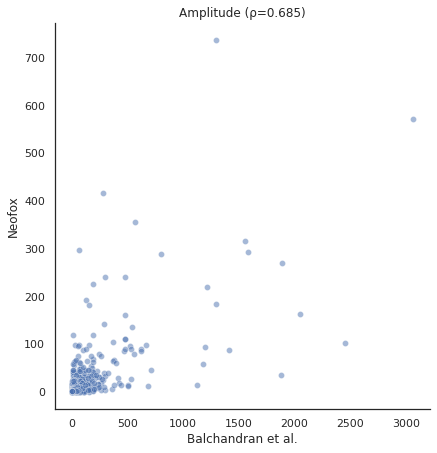

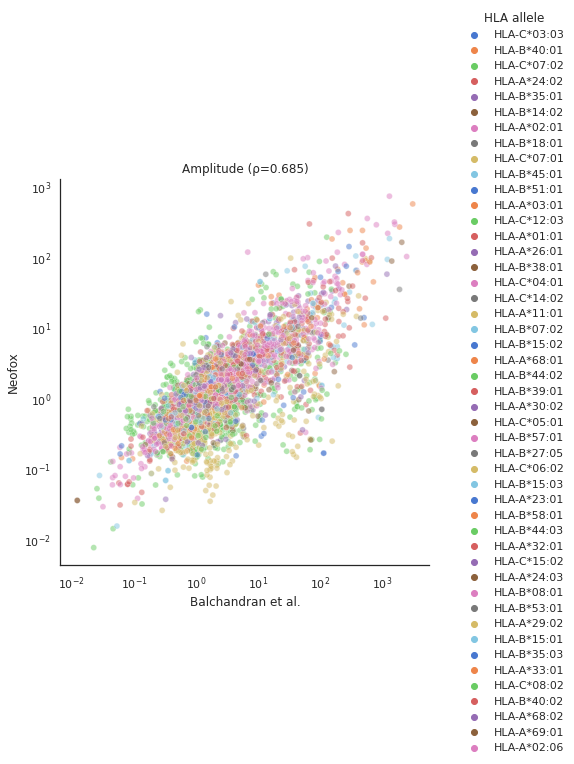

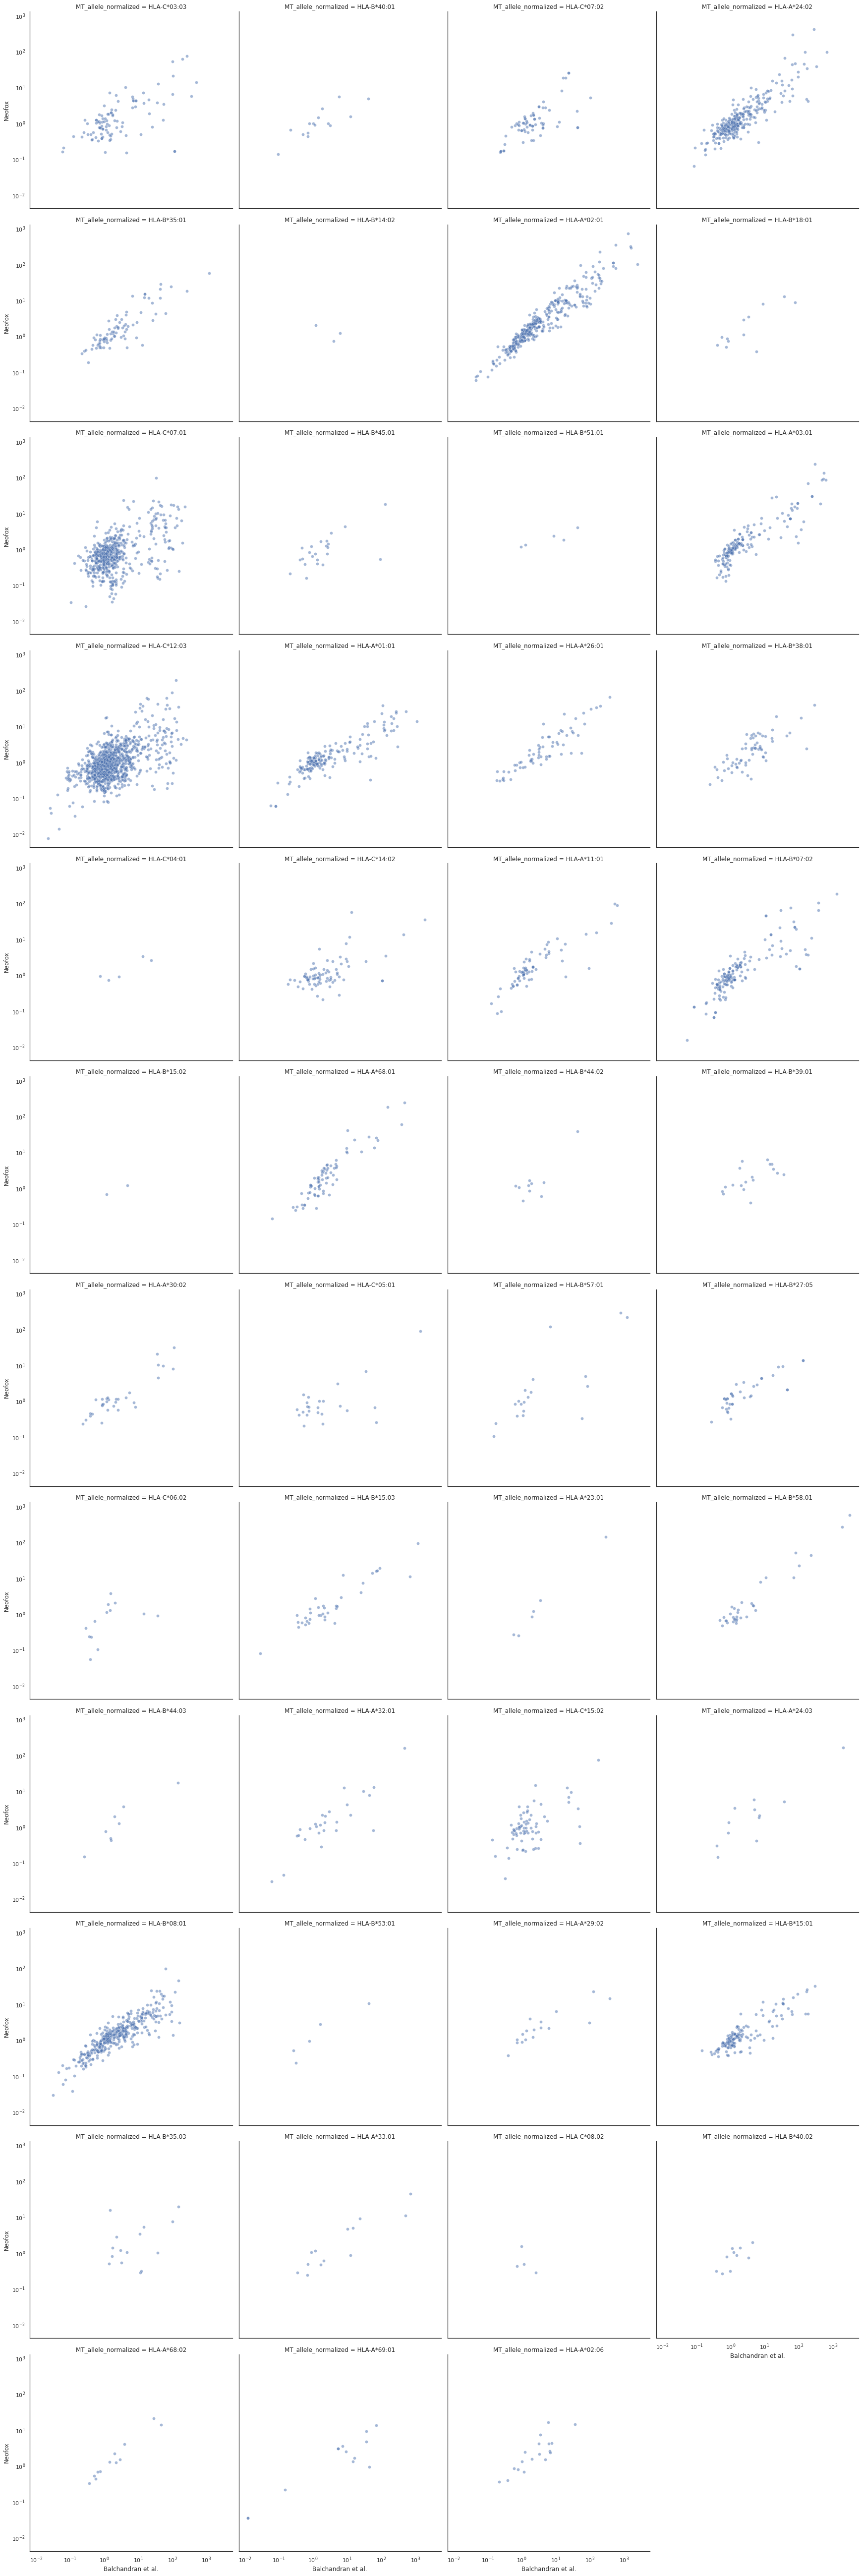

In [128]:
plot_correlations(left_column="amplitude", right_column="Amplitude_MHCI_affinity_9mer", title="Amplitude")

In [131]:
def plot_correlation_coefficient_by_allele(left_column, right_column, title):
    hla_rhos = []
    for hla in set(concordant_allele.MT_allele_normalized):
        hla_rhos.append( (hla, np.corrcoef(
            concordant_allele[concordant_allele.MT_allele_normalized == hla][left_column], 
            concordant_allele[concordant_allele.MT_allele_normalized == hla][right_column])[0][1]))

    sns.set_theme(style="whitegrid")
    sns.color_palette("coolwarm", as_cmap=True)
    hla_rhos.sort(key=lambda x: x[1])
    #plt.figure(figsize=(16, 10))
    fig, ax =plt.subplots(1,2, figsize=(20, 10))
    grid = sns.barplot(
        x=[c for _, c in hla_rhos], 
        y=[h for h, _ in hla_rhos], 
        #hue=[c for _, c in hla_rhos],
        #palette="coolwarm", 
        color="lightblue",
        ax= ax[0]
    )
    grid.set(xlabel="ρ", title="{} correlation by HLA allele".format(title))
    grid2 = sns.barplot(
        #x=[c for _, c in hla_rhos], 
        y=[h for h, _ in hla_rhos], 
        x=[concordant_allele[concordant_allele.MT_allele_normalized == h].shape[0] for h, _ in hla_rhos],
        #palette="coolwarm", 
        color="lightgreen",
        ax= ax[1]
    )
    grid2.set(xlabel="Num. candidate neoepitopes", title="Number of candidate neoepitopes across patients by HLA allele")

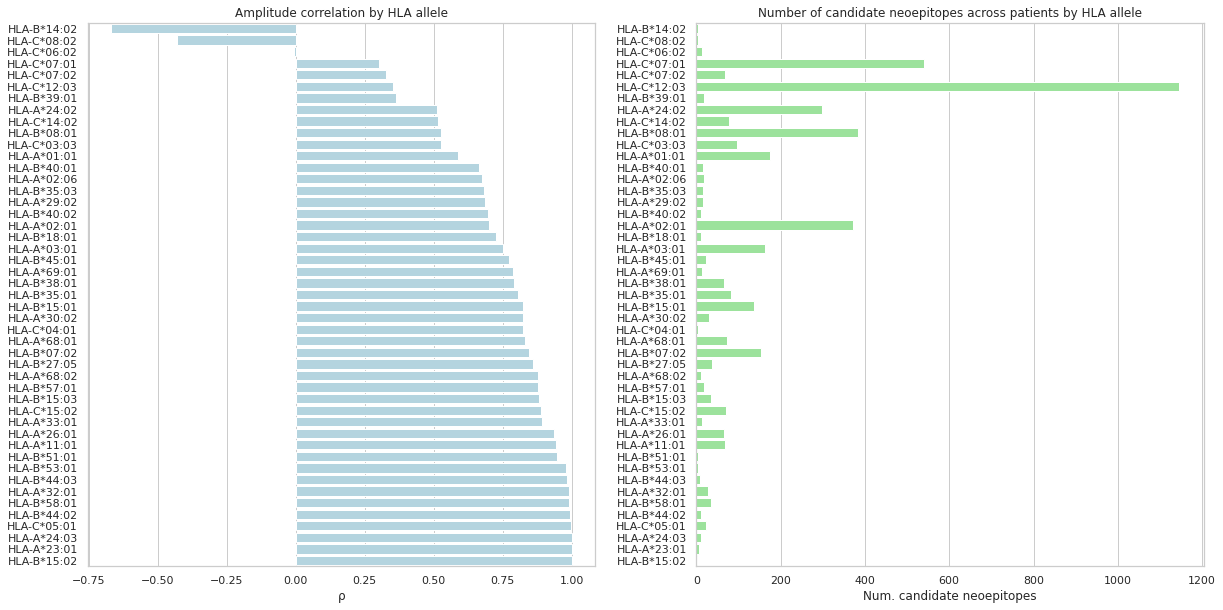

In [132]:
plot_correlation_coefficient_by_allele("amplitude", "Amplitude_MHCI_affinity_9mer", "Amplitude")plot_correlation_coefficient_by_allele("amplitude", "Amplitude_MHCI_affinity_9mer", "Amplitude")

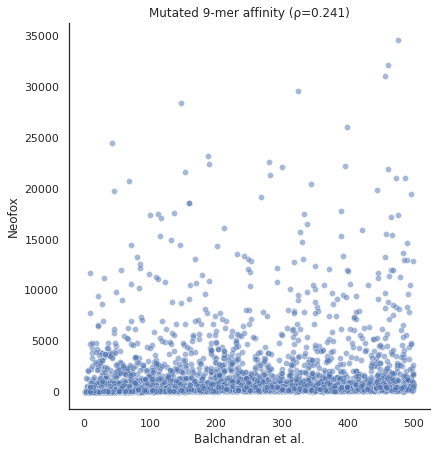

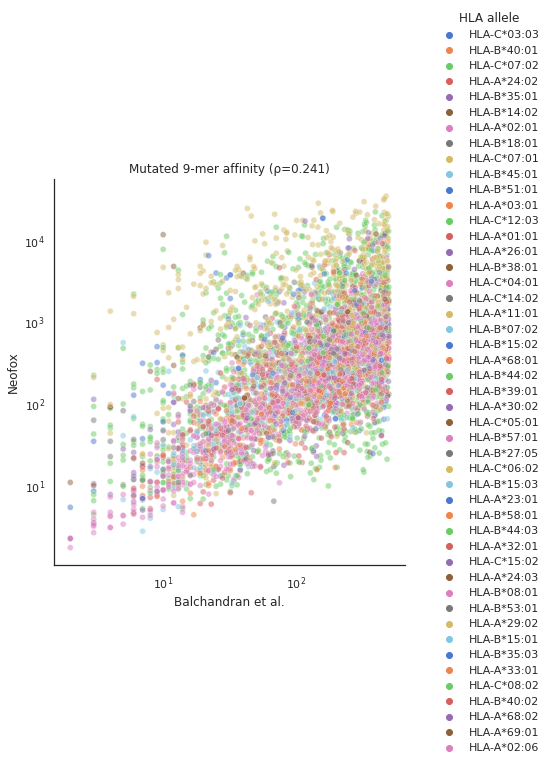

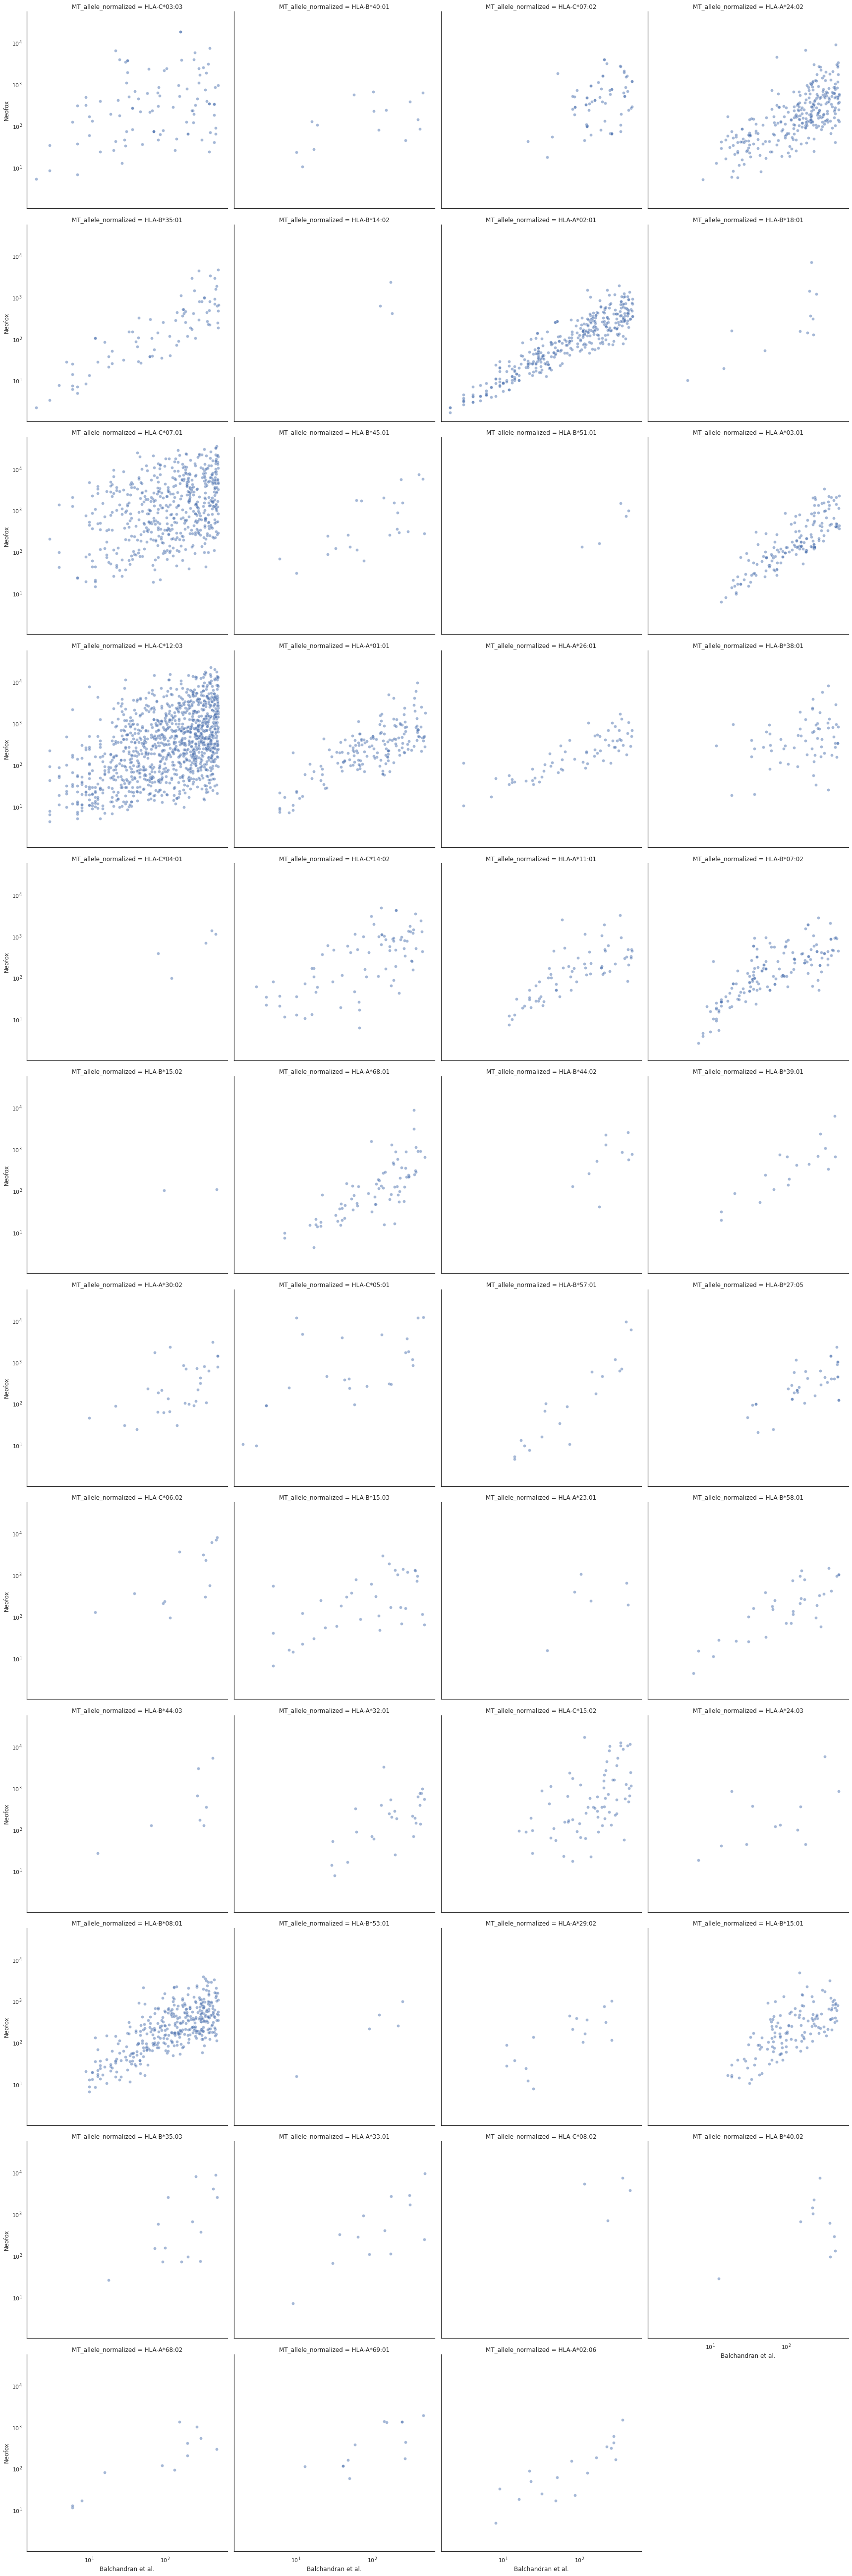

In [129]:
plot_correlations(left_column="MT Binding Score", right_column="Best_affinity_MHCI_9mer_score", title="Mutated 9-mer affinity")

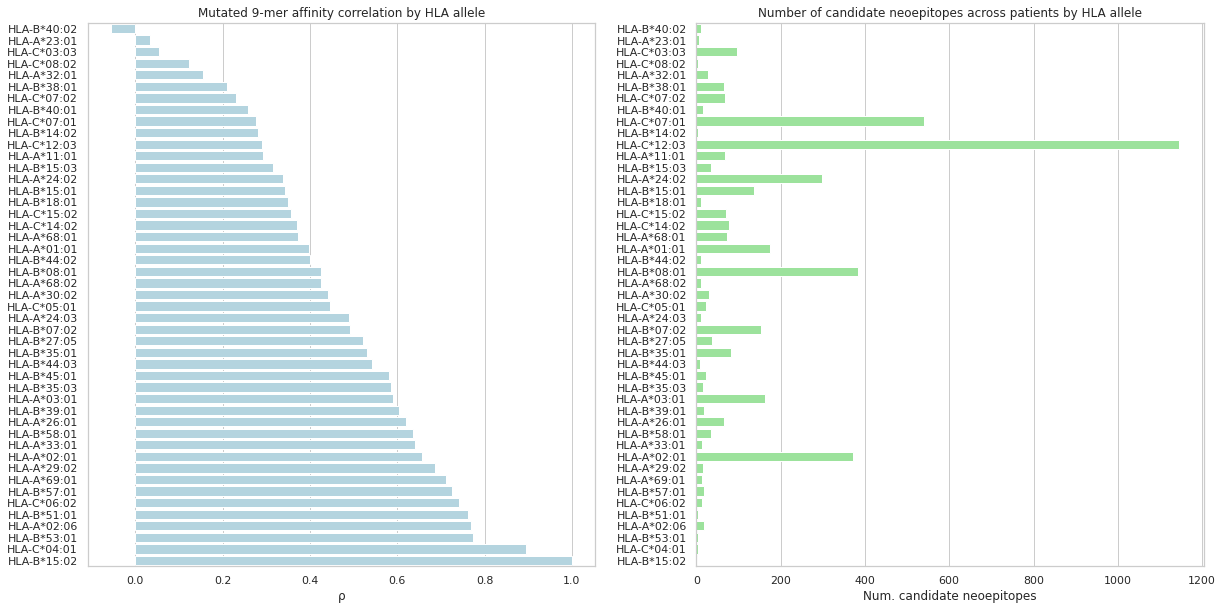

In [133]:
plot_correlation_coefficient_by_allele(left_column="MT Binding Score", right_column="Best_affinity_MHCI_9mer_score", title="Mutated 9-mer affinity")

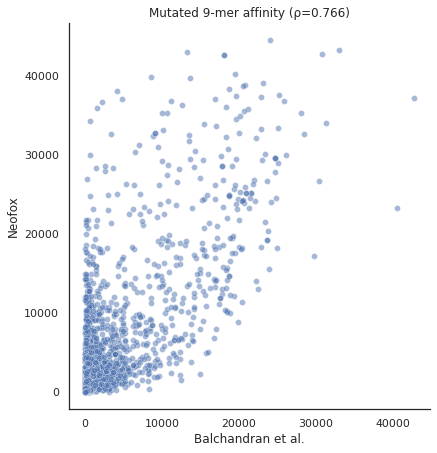

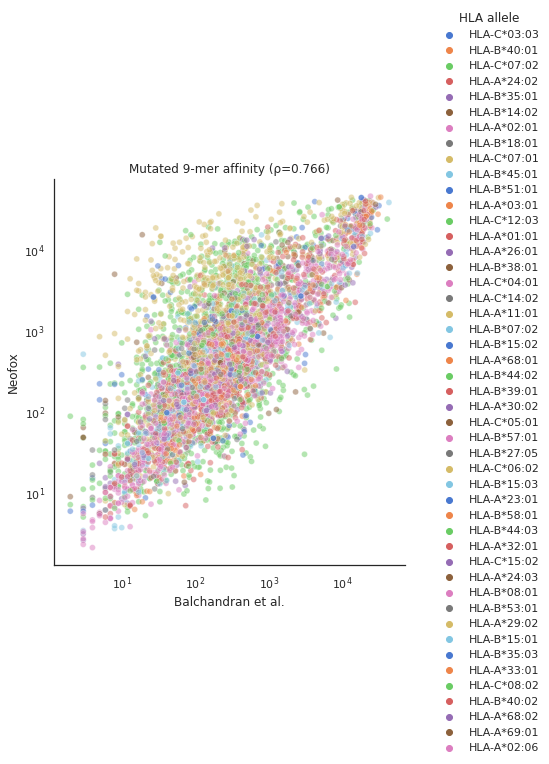

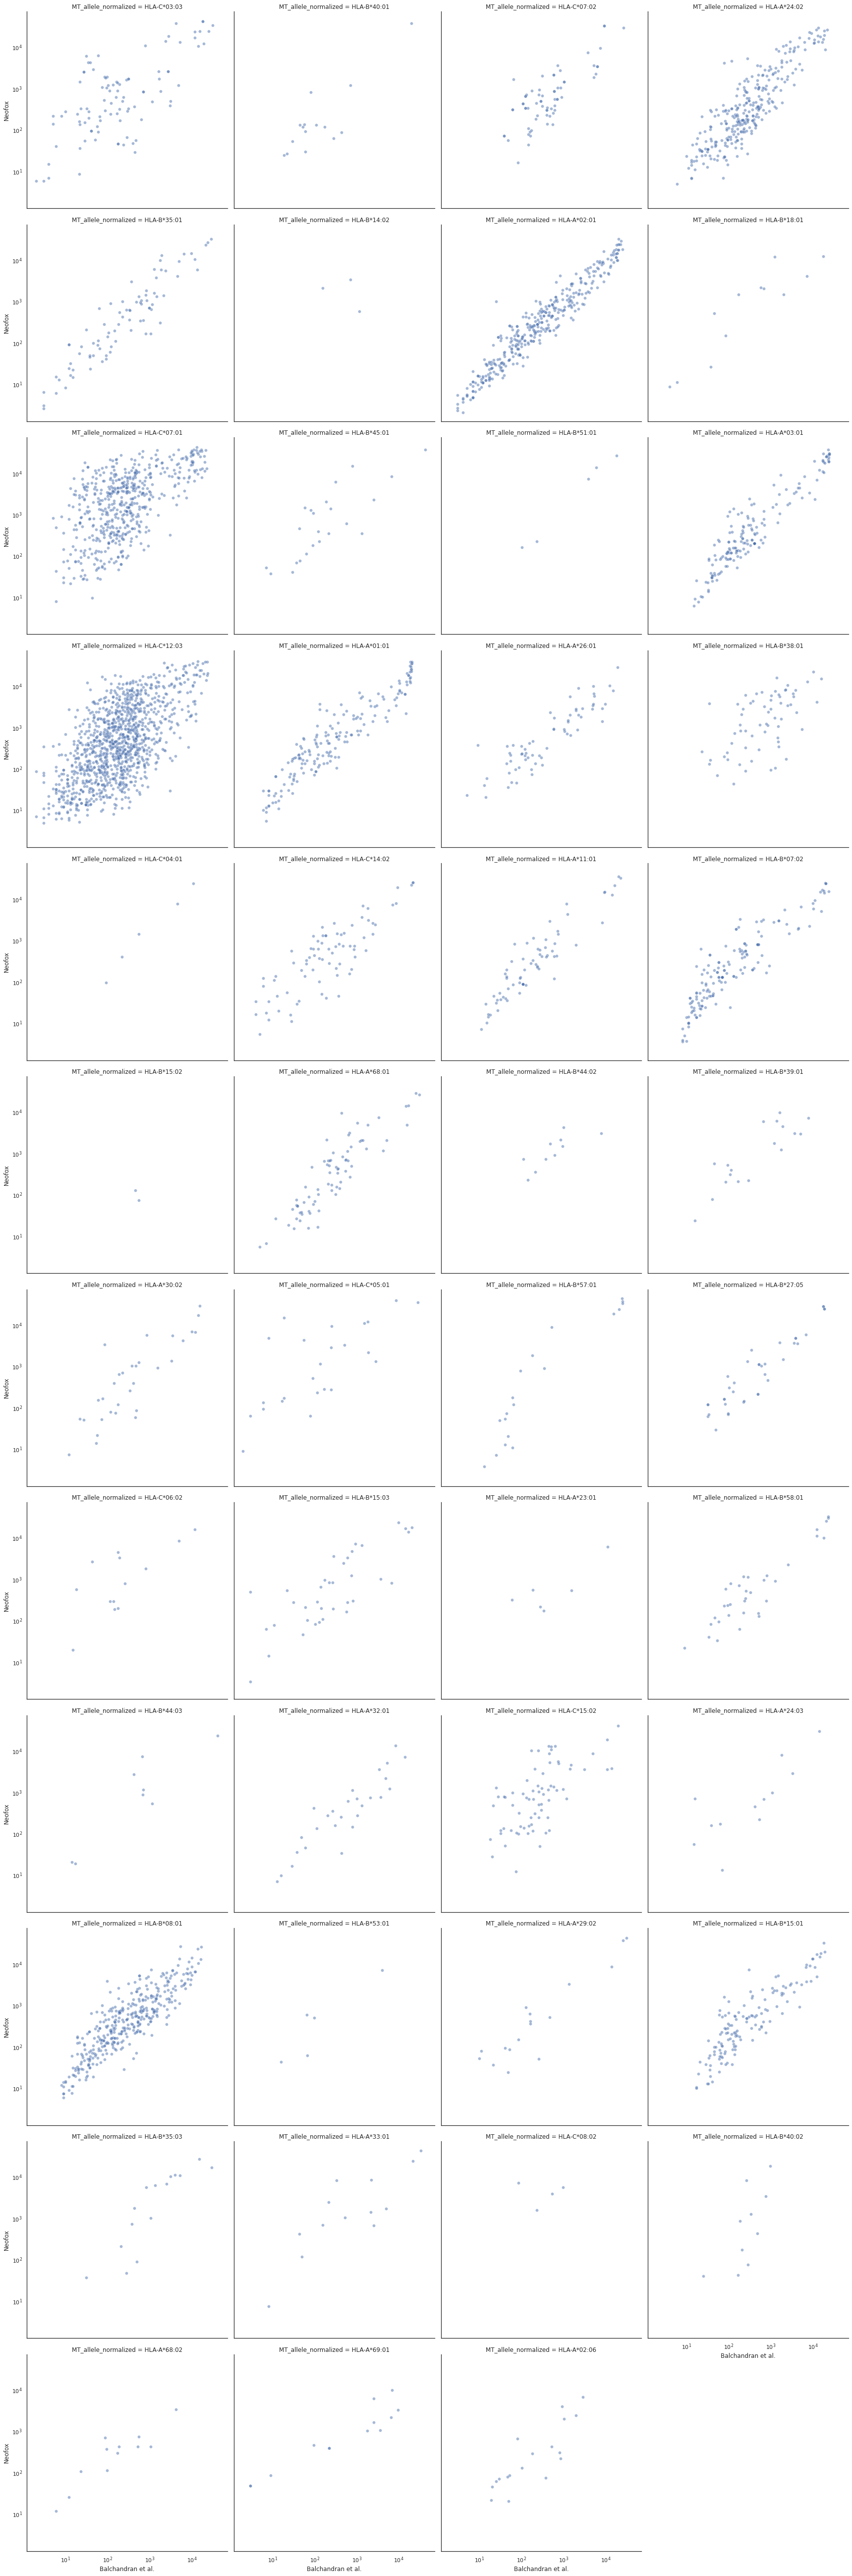

In [135]:
plot_correlations(left_column="WT Binding Score", right_column="Best_affinity_MHCI_9mer_score_WT", title="Mutated 9-mer affinity")

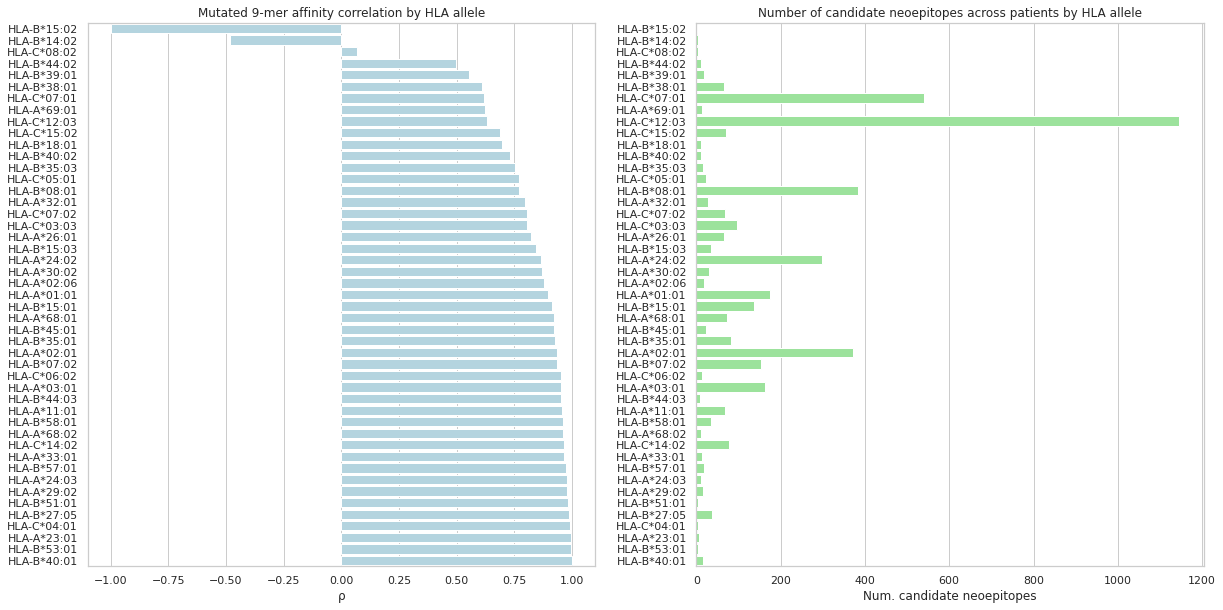

In [134]:
plot_correlation_coefficient_by_allele(left_column="WT Binding Score", right_column="Best_affinity_MHCI_9mer_score_WT", title="Mutated 9-mer affinity")

In [41]:
allele_comparison = joined_table.reset_index()[["MT_allele_normalized", "Best_affinity_MHCI_9mer_allele"]]
allele_comparison[allele_comparison["MT_allele_normalized"] != allele_comparison["Best_affinity_MHCI_9mer_allele"]].drop_duplicates()

,MT_allele_normalized,Best_affinity_MHCI_9mer_allele
4,HLA-C*03:03,HLA-B*40:01
6,HLA-C*07:02,HLA-C*03:03
15,HLA-C*03:03,HLA-A*11:02
46,HLA-A*24:02,NaN
48,HLA-A*24:02,HLA-B*35:01
55,HLA-B*14:02,HLA-B*35:01
70,HLA-B*40:01,HLA-B*18:01
83,HLA-A*02:01,HLA-C*03:04
88,HLA-B*18:01,HLA-B*40:01
93,HLA-C*07:01,HLA-C*03:04


In [42]:
unique_mismatching_alleles_neofox = allele_comparison["Best_affinity_MHCI_9mer_allele"].dropna().unique()
unique_mismatching_alleles_neofox

array(['HLA-C*03:03', 'HLA-B*40:01', 'HLA-C*07:02', 'HLA-A*11:02',
       'HLA-A*24:02', 'HLA-B*35:01', 'HLA-B*14:02', 'HLA-A*02:01',
       'HLA-B*18:01', 'HLA-C*07:01', 'HLA-C*03:04', 'HLA-B*45:01',
       'HLA-B*51:01', 'HLA-A*03:01', 'HLA-C*16:01', 'HLA-C*12:03',
       'HLA-B*35:02', 'HLA-A*01:01', 'HLA-A*26:01', 'HLA-B*38:01',
       'HLA-C*04:01', 'HLA-C*14:02', 'HLA-B*15:16', 'HLA-B*41:01',
       'HLA-A*11:01', 'HLA-B*07:02', 'HLA-B*15:02', 'HLA-A*68:01',
       'HLA-B*44:02', 'HLA-B*49:01', 'HLA-B*39:01', 'HLA-B*52:01',
       'HLA-A*30:02', 'HLA-C*05:01', 'HLA-B*57:01', 'HLA-B*27:05',
       'HLA-C*06:02', 'HLA-C*02:10', 'HLA-B*15:03', 'HLA-A*23:01',
       'HLA-C*17:01', 'HLA-B*41:02', 'HLA-B*58:01', 'HLA-B*57:03',
       'HLA-A*34:02', 'HLA-B*44:03', 'HLA-B*56:01', 'HLA-A*32:01',
       'HLA-C*15:02', 'HLA-B*27:07', 'HLA-A*02:05', 'HLA-C*15:04',
       'HLA-A*24:03', 'HLA-B*08:01', 'HLA-B*53:01', 'HLA-A*29:02',
       'HLA-B*15:01', 'HLA-B*35:03', 'HLA-A*33:01', 'HLA-C*08:

In [43]:
unique_alleles_balchandran = allele_comparison["MT_allele_normalized"].unique()
unique_alleles_balchandran

array(['HLA-C*03:03', 'HLA-B*40:01', 'HLA-C*07:02', 'HLA-A*24:02',
       'HLA-B*35:01', 'HLA-B*14:02', 'HLA-A*02:01', 'HLA-B*18:01',
       'HLA-C*07:01', 'HLA-B*45:01', 'HLA-B*51:01', 'HLA-A*03:01',
       'HLA-C*12:03', 'HLA-A*01:01', 'HLA-A*26:01', 'HLA-C*04:01',
       'HLA-B*38:01', 'HLA-C*14:02', 'HLA-A*11:01', 'HLA-B*07:02',
       'HLA-B*15:02', 'HLA-A*68:01', 'HLA-B*44:02', 'HLA-B*39:01',
       'HLA-A*30:02', 'HLA-C*05:01', 'HLA-B*57:01', 'HLA-B*27:05',
       'HLA-C*06:02', 'HLA-B*15:03', 'HLA-A*23:01', 'HLA-B*58:01',
       'HLA-B*44:03', 'HLA-A*32:01', 'HLA-C*15:02', 'HLA-A*24:03',
       'HLA-B*08:01', 'HLA-B*53:01', 'HLA-A*29:02', 'HLA-B*15:01',
       'HLA-B*35:03', 'HLA-A*33:01', 'HLA-C*08:02', 'HLA-B*40:02',
       'HLA-A*68:02', 'HLA-A*69:01', 'HLA-A*02:06'], dtype=object)

In [44]:
len(set(unique_mismatching_alleles_neofox).intersection(set(unique_alleles_balchandran)))

47

In [45]:
len(set(unique_mismatching_alleles_neofox).difference(set(unique_alleles_balchandran)))

24